# Introduction to Gen's built-in modeling language

Explain that getting good results for inference sometimes requires inference programming. This notebook just uses a single generic inference algorithm for all problems. Inference programs will be discussed in later tutorials.

Also explain that there are various extensions to the modeling language, with better performance, that will be covered in later tutorials.

Explain that we use semicolons at the end of some cells to avoid printing the last expression, e.g.:

In [6]:
a = 1 + 1

2

In [7]:
a = 1 + 1;

## Loading packages

First, we load the Gen and PyPlot Julia packages.

In [2]:
using Gen
using PyPlot

┌ Info: Recompiling stale cache file /home/marcoct/.julia/compiled/v1.0/Gen/OEZG1.ji for Gen [ea4f424c-a589-11e8-07c0-fd5c91b9da4a]
└ @ Base loading.jl:1190


## Writing a probabilistic model

In [137]:
@gen function my_model(xs::Vector{Float64})
    n = length(xs)
    slope = @addr(normal(0, 1), :slope)
    intercept = @addr(normal(0, 2), :intercept)
    for (i, x) in enumerate(xs)
        @addr(normal(slope * x + intercept, 1), (:y, i))
    end
    return nothing
end;

In [138]:
xs = [-5., -4., -3., -.2, -1., 0., 1., 2., 3., 4., 5.];

In [139]:
(trace, _) = initialize(my_model, (xs,));

In [140]:
println(trace)

Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol,Any}(), Dict{Symbol,Any}(), Type[Array{Float64,1}], getfield(Main, Symbol("##111#113"))(), getfield(Main, Symbol("##112#114"))(), Bool[false], false), Trie{Any,Gen.ChoiceRecord}(Dict{Any,Gen.ChoiceRecord}((:y, 7)=>ChoiceRecord{Float64}(2.94469, -1.30287),(:y, 9)=>ChoiceRecord{Float64}(5.09287, -1.70592),(:y, 1)=>ChoiceRecord{Float64}(-2.98249, -0.95241),(:y, 10)=>ChoiceRecord{Float64}(3.49711, -1.67064),(:y, 5)=>ChoiceRecord{Float64}(0.0910471, -0.940465),(:y, 4)=>ChoiceRecord{Float64}(0.45753, -1.06962),:intercept=>ChoiceRecord{Float64}(1.18348, -1.78716),(:y, 3)=>ChoiceRecord{Float64}(-1.22151, -0.950148),(:y, 6)=>ChoiceRecord{Float64}(1.43651, -0.95095),(:y, 8)=>ChoiceRecord{Float64}(2.24584, -1.16923),(:y, 11)=>ChoiceRecord{Float64}(5.67196, -0.920973),(:y, 2)=>ChoiceRecord{Float64}(-3.32371, -1.3869),:slope=>ChoiceRecord{Float64}(0.88494, -1.3105)), Dict{Any,Trie{Any,Gen.ChoiceRecord}}()), Trie{Any,Ge

In [141]:
println(get_args(trace))

([-5.0, -4.0, -3.0, -0.2, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0],)


In [142]:
println(get_assmt(trace))

│
├── (:y, 7) : 2.9446944849305114
│
├── (:y, 9) : 5.0928715660281165
│
├── (:y, 1) : -2.9824897649783084
│
├── (:y, 10) : 3.4971087525615547
│
├── (:y, 5) : 0.09104710171893673
│
├── (:y, 4) : 0.4575302373623288
│
├── :intercept : 1.1834776959728779
│
├── (:y, 3) : -1.2215062706719828
│
├── (:y, 6) : 1.4365062185392252
│
├── (:y, 8) : 2.2458361843851287
│
├── (:y, 11) : 5.671964900168988
│
├── (:y, 2) : -3.323712037790623
│
└── :slope : 0.8849402277522439



In [143]:
println(get_retval(trace));

ArgumentError: ArgumentError: `nothing` should not be printed; use `show`, `repr`, or custom output instead.

In [144]:
function render_trace(trace; show_data=true)
    xs = get_args(trace)[1]
    assmt = get_assmt(trace)
    if show_data
        ys = [assmt[(:y, i)] for i=1:length(xs)]
        scatter(xs, ys, c="black")
    end
    slope = assmt[:slope]
    intercept = assmt[:intercept]
    xmin = minimum(xs)
    xmax = maximum(xs)
    plot([xmin, xmax], slope *  [xmin, xmax] .+ intercept, color="black", alpha=0.5)
    ax = gca()
    ax[:set_xlim]((xmin, xmax))
    ax[:set_ylim]((xmin, xmax))
end;

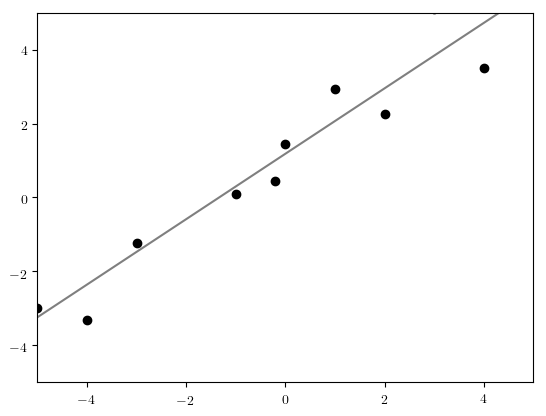

In [145]:
render_trace(trace);

In [151]:
traces = [initialize(my_model, (xs,))[1] for _=1:12];

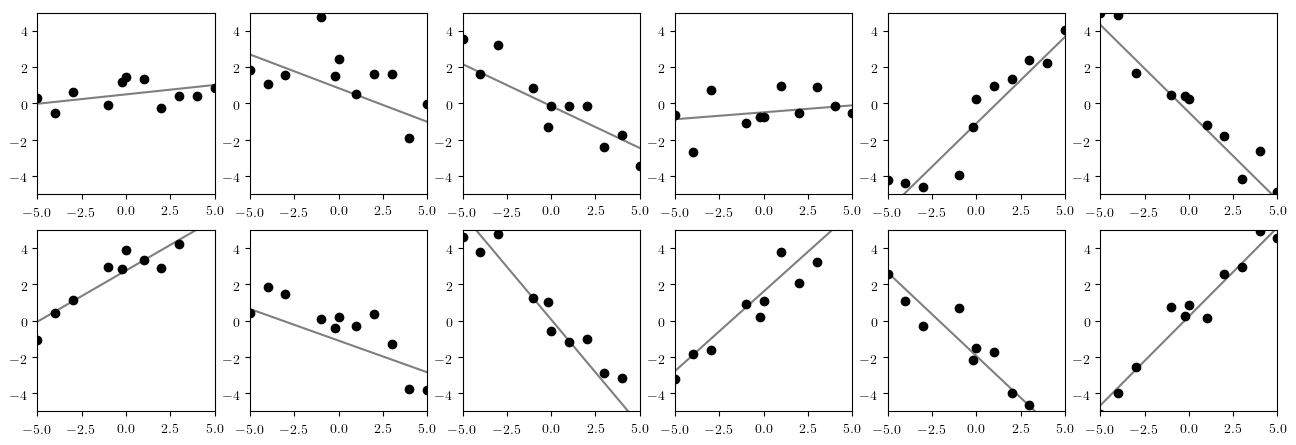

In [154]:
figure(figsize=(16, 8))
for (i, trace) in enumerate(traces)
    subplot(3, 6, i)
    render_trace(trace)
end

### Exercise
write a model that genreates sine waves of unknown phase, period and amplitude.
hint: use a gamma(1, 1) distribution for the prior on period and amplitude, and a uniform distribution for the phase

In [177]:
@gen function sine_model(xs::Vector{Float64})
    period = @addr(gamma(1, 1), :period)
    amplitude = @addr(gamma(1, 1), :amp)
    phase = @addr(uniform(0, 2*pi), :phase)
    for (i, x) in enumerate(xs)
        @addr(normal(amplitude * sin(x * (2 * pi / period) + phase), 0.1), (:y, i))
    end
    return nothing
    end;

In [181]:
function render_sine_trace(trace; show_data=true)
    xs = get_args(trace)[1]
    assmt = get_assmt(trace)
    if show_data
        ys = [assmt[(:y, i)] for i=1:length(xs)]
        scatter(xs, ys, c="black")
    end
    period = assmt[:period]
    amp = assmt[:amp]
    phase = assmt[:phase]
    xmin = minimum(xs)
    xmax = maximum(xs)
    test_xs = collect(range(-5, stop=5, length=100))
    plot(test_xs, amp * sin.(test_xs * (2 * pi / period) .+ phase), color="black", alpha=0.5)
    ax = gca()
    ax[:set_xlim]((xmin, xmax))
    ax[:set_ylim]((xmin, xmax))
end;

In [182]:
traces = [initialize(sine_model, (xs,))[1] for _=1:12];

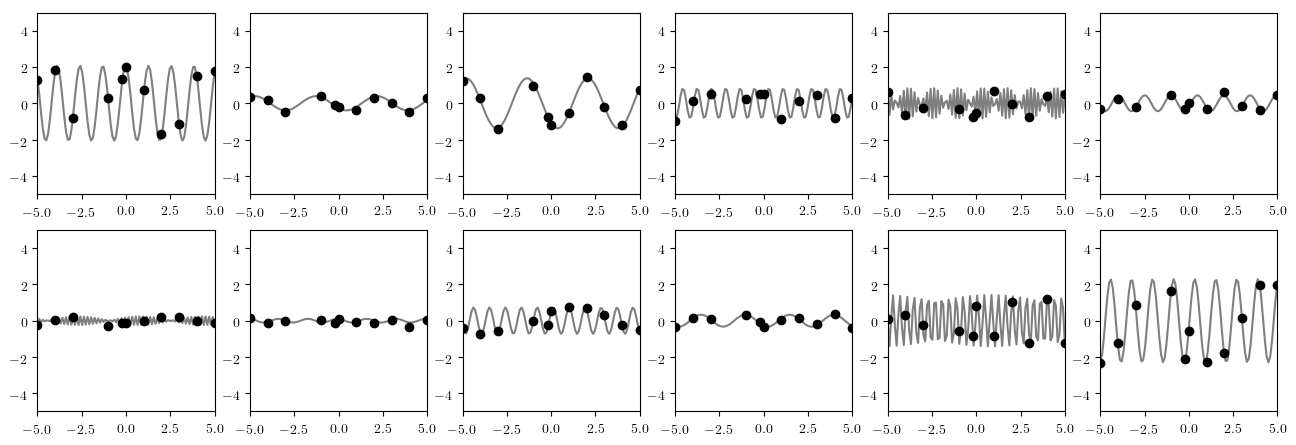

In [183]:
figure(figsize=(16, 8))
for (i, trace) in enumerate(traces)
    subplot(3, 6, i)
    render_sine_trace(trace)
end

## Doing Bayesian inference

In [232]:
ys = xs * -1 .+ 2 .+ randn(length(xs)) * 0.5;

In [233]:
observations = DynamicAssignment()
for (i, y) in enumerate(ys)
    observations[(:y, i)] = y
end

In [234]:
(trace, _) = importance_resampling(my_model, (xs,), observations, 100);

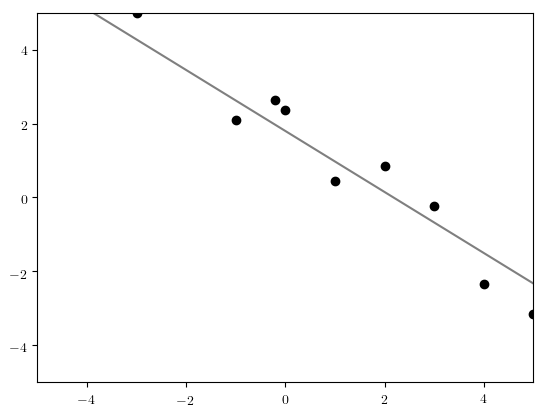

(-5.0, 5.0)

In [235]:
render_trace(trace)

In [236]:
function overlay(renderer, traces)
    renderer(traces[1], show_data=true)
    for i=2:length(traces)
        renderer(traces[i], show_data=false)
    end
end;

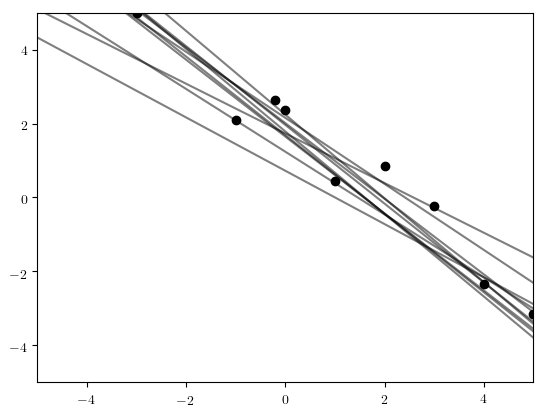

In [237]:
traces = [importance_resampling(my_model, (xs,), observations, 100)[1] for _=1:10];
overlay(render_trace, traces)

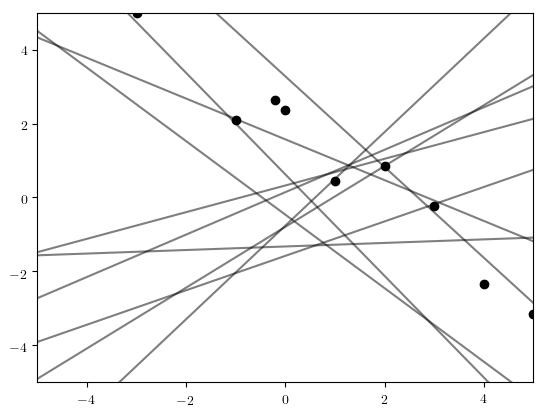

In [238]:
traces = [importance_resampling(my_model, (xs,), observations, 1)[1] for _=1:10];
overlay(render_trace, traces)

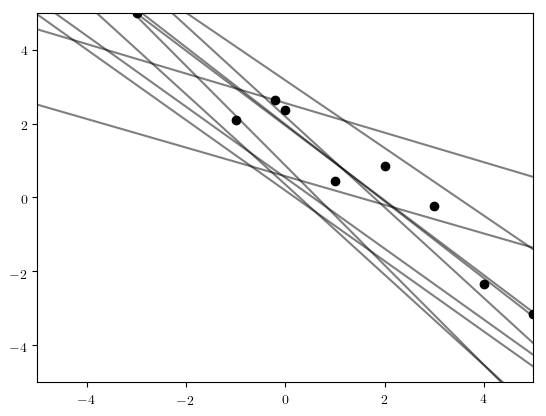

In [239]:
traces = [importance_resampling(my_model, (xs,), observations, 10)[1] for _=1:10];
overlay(render_trace, traces)

### Exercise
for the sine wave model, come up with a dataset and confirm that inference works. how many iterations do you need to get good results?
compare with inference results for the original model 'model'.
interpret the results. change the prior on the period

In [244]:
ys = 3 * sin.(xs) + randn(length(xs)) * 0.1;

In [245]:
observations = DynamicAssignment()
for (i, y) in enumerate(ys)
    observations[(:y, i)] = y
end

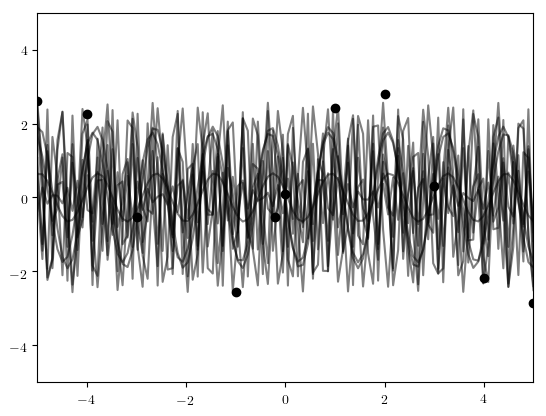

In [253]:
traces = [importance_resampling(sine_model, (xs,), observations, 100)[1] for _=1:10];
overlay(render_sine_trace, traces)

In [279]:
@gen function sine_model_new(xs::Vector{Float64})
    period = @addr(gamma(3, 1), :period)
    amplitude = @addr(gamma(1, 1), :amp)
    phase = @addr(uniform(0, 2*pi), :phase)
    for (i, x) in enumerate(xs)
        @addr(normal(amplitude * sin(x * (2 * pi / period) + phase), 0.1), (:y, i))
    end
    return nothing
    end;

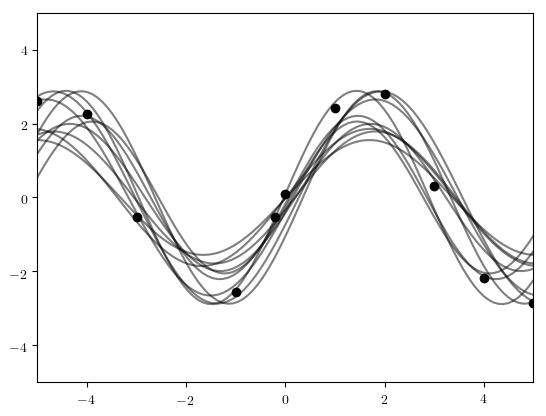

In [282]:
traces = [importance_resampling(sine_model_new, (xs,), observations, 1000)[1] for _=1:10];
overlay(render_sine_trace, traces)

### Exercise
come up with a data set that will cause the posterior to be concentrated around a slope of 0 and an intercept of -1. run inference in that model and visualize to confirm the results

### Exercise
what do you expect the posterior for this data set to look like?
run inference, is that what you expected?
how can you make it more uncertain?
hint: make the noise variable be sampled from a gamma(1, 1) distribution.
visualize the results to confirm.

## Discete random choices
show a generative function that calls another generative function.
show that you can also use splice.

### Exercise 
Modify the model so that it doesn't invoke a separate generative function for the error model.

### Exercise
write a generative function that generates a random string of length 5
modify the model so that with probability 1/3 it samples a random string
also, make the error rate a random choice (use a beta(1, 2) prior)
Q: what is the prior probability of 'and' and what is the prior probability of 'the' (answer: 1/3 + 1/(26^3))

## Compositional discrete hypothesis spaces

### Exercise
implement a generative function that samples strings from a probabilistic context-free grammar using recursion
first do a version that uses `addr` and then a version that uses `splice`.
Q: compute the probability that the string is length 1 as a function of p
Q: are their values of p for which the probability of any string is not 1?